In [26]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os

def import_from_excel(e_file, filename):
    kinase_targets = e_file['kinase target'].tolist()[0] #just the top score
    JS_scores = e_file['JS Distance Score'].tolist()[0] #just the top score
    #off_targets = e_file['off-target %inhibition values'].tolist()
    mu = int(filename.split('.')[0].split('_')[-2])
    return [mu, kinase_targets, JS_scores] #off_targets]

test_results_200 = []
test_results_700 = []

test_results = {}

for filename in os.listdir(os.getcwd()+'/results/'):
    if filename[0] != '~':
        f = './results/'+str(filename)
        replicate_results = []
        targets = ''
        for x in range(1,4):
            open_file = pd.read_excel(f, str(x), engine='openpyxl')
            inhibitor_combination = import_from_excel(open_file, filename)
            targets = inhibitor_combination[1]
            replicate_results.append((x,inhibitor_combination))
        if targets not in test_results:
            test_results[targets] = [[],[]]
        if replicate_results[0][1][0] == 200:
            test_results[targets][0].append(replicate_results)
            #test_results_200.append(replicate_results)
        elif replicate_results[0][1][0] == 700:
            test_results[targets][1].append(replicate_results)
            #test_results_700.append(replicate_results)
        
#check to make sure we have 5 sets of results for each  
for k in test_results:
    print(len(test_results[k][0]))
    print(len(test_results[k][1]))

5
5
5
5


In [56]:
#sig results

sig_results = {}

for k in test_results:
    res_200 = test_results[k][0]
    res_700 = test_results[k][1]
    
    #get the average i=1score
    i_1_200_vals = [r[0][1][2] for r in res_200 if r[0][0] == 1]
    i_1_700_vals = [r[0][1][2] for r in res_700 if r[0][0] == 1]
    
    sig_200_scores = []
    sig_700_scores = []
    
    sig_dist_200 = 0
    sig_dist_700 = 0
    
    #get the vals at each higher combo number. test if sig. if so, save those vals
    for i in range(1, len(res_200[0])):
        i_vals = [r[i][1][2] for r in res_200]
        #test if sig diff or not
        tval, pval = stats.ttest_ind(i_1_200_vals, i_vals)
        if (pval < 0.05) and (np.mean(i_1_200_vals)+0.001 < np.mean(i_vals)):
            if np.mean(i_vals) - np.mean(i_1_200_vals) > sig_dist_200:
                sig_200_scores = i_vals
                sig_dist_200 = (np.mean(i_1_200_vals) - np.mean(i_vals))
            
    #get the vals at each higher combo number. test if sig. if so, save those vals
    for i in range(1, len(res_700[0])):
        i_vals = [r[i][1][2] for r in res_700]
        #test if sig diff or not
        tval, pval = stats.ttest_ind(i_1_700_vals, i_vals)
        if (pval < 0.05) and (np.mean(i_1_700_vals)+0.001 < np.mean(i_vals)):
            if np.mean(i_vals) - np.mean(i_1_700_vals) > sig_dist_700:
                sig_700_scores = i_vals
                sig_dist_700 = (np.mean(i_1_200_vals) - np.mean(i_vals))
    
    if sig_200_scores != [] or sig_700_scores != []:
        knames = test_results[k][0][1][0][1][1]
        knames = knames.strip('][').replace('\'', '').replace(', ', '_')
        sig_results[knames] = [sig_200_scores,sig_700_scores,i_1_200_vals,i_1_700_vals]
        
print(sig_results)
            
    

YES_FES
{'YES_FES': [[0.9022443857493129, 0.9018157754334722, 0.901063720606214, 0.9015250445034878, 0.9021191762390312], [0.8558940040132341, 0.856025770270688, 0.8565996068478162, 0.8570635810347951, 0.856890390807179], [0.8433859426293795, 0.842311768402843, 0.8421961594611304, 0.8416935773059567, 0.8423178785976548], [0.7906321925619958, 0.7890390929163142, 0.7901448253572666, 0.7915084328108642, 0.7918728927113866]]}


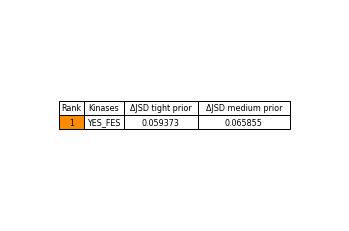

In [58]:
#Get the names and delta score of all the significant results

#Who are the kinases that showed statistically significant improvement?

n700 = 0
n200 = 0
both = 0

res = []
for kres in sig_results:
    sig_200_scores = sig_results[kres][0]
    sig_700_scores = sig_results[kres][1]
    i_1_200_vals = sig_results[kres][2]
    i_1_700_vals = sig_results[kres][3]
    sig=0
    if sig_200_scores == []:
        mu200 = 'N/A'
    else:
        sig+=1
    if sig_700_scores == []:
        mu700 = 'N/A'
    else:
        sig+=2
    if sig>=1:
        scolor = 'w'
        if sig == 1:
            n200 += 1
            scolor = 'darkred'
        if sig == 2:
            n700 += 1
            scolor = 'b'
        if sig == 3:
            both += 1
            scolor = 'darkorange'
            
        mu200 = 0
        mu700 = 0
        if sig == 1 or sig == 3:
            mu200 = np.mean(sig_200_scores) - np.mean(i_1_200_vals)
        if sig == 2 or sig == 3:
            mu700 = np.mean(sig_700_scores) - np.mean(i_1_700_vals)
            
        tscore = mu200+mu700
            
        res.append((tscore,kres,mu200,mu700,scolor))
            
tabled = []
cell_color = []
tabled.append(['Rank','Kinases','ΔJSD tight prior','ΔJSD medium prior'])
cell_color.append(['w','w','w','w'])
res = sorted(res, key=lambda x: x[0], reverse=True)
counter = 1
for k in res:
    tabled.append([counter,k[1],round(k[2], 6),round(k[3],6)])
    color_val = k[4]
    cell_color.append([color_val,'w','w','w',])
    counter+=1
    
fig, ax = plt.subplots()
table = ax.table(cellText=tabled, loc='center',cellLoc='center',cellColours=cell_color)
table.auto_set_font_size(False)
table.auto_set_column_width(col=[0,1,2,3])
table.set_fontsize(8)
table.scale(1,1.2)
ax.axis('off')
plt.show()
#fig.savefig("120821_PKIS2_JSD_700v200_45k_improvement_table.pdf", bbox_inches='tight',dpi=500)

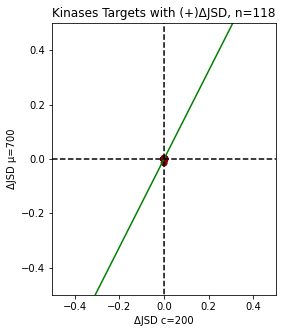

In [4]:
#check to see what the maximum inhibitor concentration # is that we should use
import matplotlib.patches as mpatches
max_inhib_num = len(test_results_200[0])

#for each kinase, get the set of scores at i=1, i=2, i=3 etc

organized_results_200 = {}
organized_results_700 = {}

for replicate_200 in test_results_200:    #in each of the 5 test replicates
    for individual_result in replicate_200:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_200:
                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            
for replicate_700 in test_results_700:    #in each of the 5 test replicates
    for individual_result in replicate_700:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_700:
                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

#determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
#and if that difference is significant or not

x_200_scored_kinase_names = []
x_200_values = []
x_sig = []
max_200_vals = []

y_700_scored_kinase_names = []
y_700_values = []
y_sig = []
max_700_vals = []

for kinase in organized_results_200:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_200[kinase][0])
    i1_values = organized_results_200[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_200[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_200[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_200[kinase][j]
    max_200_vals.append(max_other_combination)
    #is the difference significant?
    tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
    if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean)):
        significant = 1
    JS_score_difference = max_other_combination - i1_mean
    x_200_scored_kinase_names.append(kinase)
    x_200_values.append(JS_score_difference)
    x_sig.append(significant)
    
for kinase in organized_results_700:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_700[kinase][0])
    i1_values = organized_results_700[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_700[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_700[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_700[kinase][j]
    max_700_vals.append(max_other_combination)
    #is the difference significant?
    tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
    if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean)):
        significant = 2
    JS_score_difference = max_other_combination - i1_mean
    y_700_scored_kinase_names.append(kinase)
    y_700_values.append(JS_score_difference)
    y_sig.append(significant)
    
#for each kinase in PKIS2, get the x_val, the y_val, the total significance

final_kinases = []
final_x = []
final_y = []
sum_sig = []

for kinase_target in all_kinase_names:
    #final_kinases.append(kinase_target)
    
    add = False
    x_index = None
    y_index = None
    
    if kinase_target in x_200_scored_kinase_names:
        x_index = x_200_scored_kinase_names.index(kinase_target)
        #final_x.append(x_200_values[x_index])
        if x_sig[x_index] > 0:
            add=True
        #sum_sig.append(x_sig[index])
    #else:
        #final_x.append(0)
        #sum_sig.append(0)
    if kinase_target in y_700_scored_kinase_names:
        y_index = y_700_scored_kinase_names.index(kinase_target)
        if y_sig[y_index] > 0:
            add = True
        #final_y.append(y_700_values[index])
        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
    #else:
        #final_y.append(0)
    if add:
        final_x.append(x_200_values[x_index])
        final_y.append(y_700_values[y_index])
        sum_sig.append(x_sig[x_index]+y_sig[y_index])
        final_kinases.append(kinase_target)

#convert significane to a different color for the points
#black = not significant
#yellow = significant for 200 (1)
#blue = significant for 700 (2)
#cyan = significant for both (3)
point_color = []
total = 0
for value in sum_sig:
    if value == 1:
        point_color.append('darkred')
        total+=1
    elif value == 2:
        point_color.append('b')
        total+=1
    elif value == 3:
        point_color.append('darkorange')
        total+=1
    else:
        point_color.append('k')
       
fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))
plt.xlabel('ΔJSD c=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

#fig.savefig("120121_PKIS2_JSD_700v200_scatterplot.pdf", bbox_inches='tight',dpi=500)

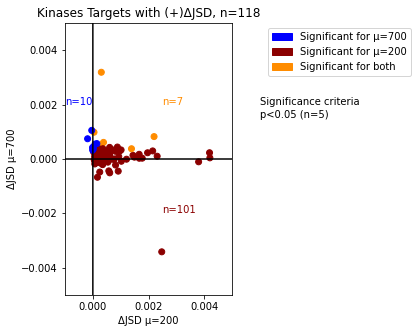

In [5]:
#replot with tighter axis

fig = plt.figure(figsize=(3, 5))

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

#plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k-')
plt.plot(zeros,yv,'k-')

plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
    #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.001,0.005))
plt.ylim((-0.005,0.005))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other
u700ldg = mpatches.Patch(color='b', label='Significant for μ=700')
u200ldg = mpatches.Patch(color='darkred', label='Significant for μ=200')
bothldg = mpatches.Patch(color='darkorange', label='Significant for both')

fig.legend(handles=[u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.75, 0.88))

plt.text(-0.001,0.002,'n=10', color='b')
plt.text(0.0025,-0.002,'n=101', color='darkred')
plt.text(0.0025,0.002,'n=7', color='darkorange')

plt.text(0.006,0.002,'Significance criteria')
plt.text(0.006,0.0015,'p<0.05 (n=5)')

plt.show()

fig.savefig("120821_PKIS2_JSD_700v200_scatterplot_118sig_zoomin.pdf", bbox_inches='tight',dpi=500)

In [6]:
#Who are the kinases that showed statistically significant improvement?

print('average 200 i=1 score:' + str(np.mean(mu200)))
print('average 700 i=1 score:' + str(np.mean(mu700)))


n700 = 0
n200 = 0
both = 0

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=1:
        res.append((tscore,k,mu200,mu700))
        if sig == 1:
            n200 += 1
        if sig == 2:
            n700 += 1
        if sig == 3:
            both += 1
print(n700,n200,both)
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=700')
counter = 1
for k in res:
    print(counter,k[1],k[2],k[3])
    counter+=1
    

average 200 i=1 score:0.9776575333619669
average 700 i=1 score:0.9637547722601488
10 101 7
kinase ΔJSD_μ=200 ΔJSD_μ=700
1 BMPR1B 0.004182360693890552 0.00022700713119339078
2 FGFR4 0.004194319011110892 3.886130272012789e-05
3 EPHA8 0.0037910280522712725 -0.00010687221492633459
4 CSNK1A1 0.00030335881300735945 0.00318798132799325
5 GSK3A 0.002194091659006081 0.0008210153551221344
6 CIT 0.002144517641026633 0.00029367453791351306
7 PIK3CG 0.0023047831055932333 9.851344682110241e-05
8 DYRK1A 0.0019614853195640825 0.00022562553779725825
9 CSNK1E 0.0016598962412605056 0.0001692097981731422
10 CSNK1G3 0.0017692830580562369 2.661939775328026e-05
11 MEK1 0.0013848599944994433 0.00037402485642024086
12 WNK2 0.0016627075138977432 2.4034620114354865e-05
13 CLK1 0.0014376613566566832 0.000131582664440133
14 INSR 0.0014898177489461872 6.401094971442145e-05
15 TAK1 0.001012486283943126 0.0003301163970539367
16 TRKA 0.0008793164795370956 0.00043627700821924353
17 KIT 0.0009721245030680503 0.000297380

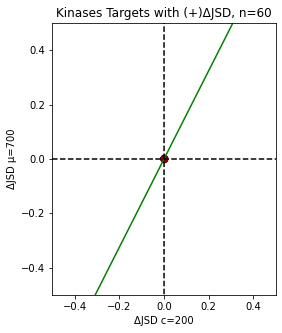

In [11]:
# Same as above but set a threshold for changes that are more relevant versus less relevant
# Count the number of kinases that fall over this threshold

#check to see what the maximum inhibitor concentration # is that we should use
max_inhib_num = len(test_results_200[0])

#for each kinase, get the set of scores at i=1, i=2, i=3 etc

organized_results_200 = {}
organized_results_700 = {}

for replicate_200 in test_results_200:    #in each of the 5 test replicates
    for individual_result in replicate_200:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_200:
                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            
for replicate_700 in test_results_700:    #in each of the 5 test replicates
    for individual_result in replicate_700:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_700:
                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

#determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
#and if that difference is significant or not

x_200_scored_kinase_names = []
x_200_values = []
x_sig = []
max_200_vals = []
stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_200_i1_scores = [] #the raw scores
JSD_200_max_scores = [] #the raw scores

y_700_scored_kinase_names = []
y_700_values = []
y_sig = []
max_700_vals = []
stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_700_i1_scores = [] #the raw scores
JSD_700_max_scores = [] #the raw scores

for kinase in organized_results_200:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_200[kinase][0])
    i1_values = organized_results_200[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_200[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_200[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_200[kinase][j]
    if max_other_combination_values != []:
        max_200_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_200.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.01) and (np.mean(max_other_combination_values) > (i1_mean)):
            significant = 1
        JS_score_difference = max_other_combination - i1_mean
        x_200_scored_kinase_names.append(kinase)
        x_200_values.append(JS_score_difference)
        x_sig.append(significant)
        JSD_200_i1_scores.append(i1_values)
        JSD_200_max_scores.append(max_other_combination_values)
        
    
for kinase in organized_results_700:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_700[kinase][0])
    i1_values = organized_results_700[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_700[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_700[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_700[kinase][j]
    if max_other_combination_values != []:
        max_700_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_700.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.01) and (np.mean(max_other_combination_values) > (i1_mean)):
            significant = 2
        JS_score_difference = max_other_combination - i1_mean
        y_700_scored_kinase_names.append(kinase)
        y_700_values.append(JS_score_difference)
        y_sig.append(significant)
        JSD_700_i1_scores.append(i1_values)
        JSD_700_max_scores.append(max_other_combination_values)
    
#for each kinase in PKIS2, get the x_val, the y_val, the total significance

final_kinases = []
final_x = []
final_y = []
sum_sig = []

final_std_200 = []
final_std_700 = []

final_JSD_200_i1 = []
final_JSD_700_i1 = []
final_JSD_200_max = []
final_JSD_700_max = []

final_JSD_200_i1_stdev = []
final_JSD_700_i1_stdev = []
final_JSD_200_max_stdev = []
final_JSD_700_max_stdev = []

for kinase_target in all_kinase_names:
    #final_kinases.append(kinase_target)
    
    add = False
    x_index = None
    y_index = None
    
    if kinase_target in x_200_scored_kinase_names:
        x_index = x_200_scored_kinase_names.index(kinase_target)
        #final_x.append(x_200_values[x_index])
        if x_sig[x_index] > 0:
            add=True
        #sum_sig.append(x_sig[index])
    #else:
        #final_x.append(0)
        #sum_sig.append(0)
    if kinase_target in y_700_scored_kinase_names:
        y_index = y_700_scored_kinase_names.index(kinase_target)
        if y_sig[y_index] > 0:
            add = True
        #final_y.append(y_700_values[index])
        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
    #else:
        #final_y.append(0)
    if add:
        final_x.append(x_200_values[x_index])
        final_y.append(y_700_values[y_index])
        sum_sig.append(x_sig[x_index]+y_sig[y_index])
        final_kinases.append(kinase_target)
        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score
        
        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))
        
        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
        

#convert significane to a different color for the points
#black = not significant
#yellow = significant for 200 (1)
#blue = significant for 700 (2)
#cyan = significant for both (3)
point_color = []
total = 0
for value in sum_sig:
    if value == 1:
        point_color.append('darkred')
        total+=1
    elif value == 2:
        point_color.append('b')
        total+=1
    elif value == 3:
        point_color.append('darkorange')
        total+=1
    else:
        point_color.append('k')
       
fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))
plt.xlabel('ΔJSD c=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

#fig.savefig("120121_PKIS2_JSD_700v200_scatterplot.pdf", bbox_inches='tight',dpi=500)



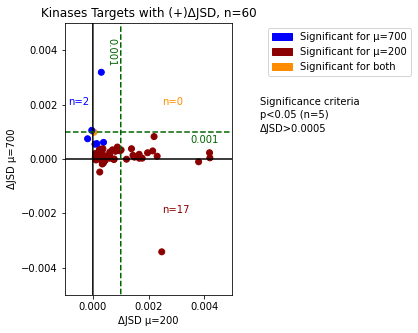

In [12]:
#replot with tighter axis

fig = plt.figure(figsize=(3, 5))

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

#plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k-')
plt.plot(zeros,yv,'k-')

threshlimit = np.arange(-1,1,0.0001)
tlim = [0.001]*len(threshlimit)

plt.plot(threshlimit,tlim,'--',color='darkgreen')
plt.plot(tlim,threshlimit,'--',color='darkgreen')

plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
    #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.001,0.005))
plt.ylim((-0.005,0.005))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other
u700ldg = mpatches.Patch(color='b', label='Significant for μ=700')
u200ldg = mpatches.Patch(color='darkred', label='Significant for μ=200')
bothldg = mpatches.Patch(color='darkorange', label='Significant for both')

fig.legend(handles=[u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.75, 0.88))

plt.text(0.0035,0.0006,'0.001', color='darkgreen')
plt.text(0.0005,0.0035,'0.001', color='darkgreen',rotation=-90)

plt.text(-0.0009,0.002,'n=2', color='b')
plt.text(0.0025,-0.002,'n=17', color='darkred')
plt.text(0.0025,0.002,'n=0', color='darkorange')

plt.text(0.006,0.002,'Significance criteria')
plt.text(0.006,0.0015,'p<0.05 (n=5)')
plt.text(0.006,0.001,'ΔJSD>0.0005')

plt.show()

fig.savefig("120821_PKIS2_JSD_700v200_scatterplot_45sig_zoomin.pdf", bbox_inches='tight',dpi=500)

average 200 i=1 score:0.00023299658249853472
average 700 i=1 score:0.0001427891330879616
6 53 1
kinase ΔJSD_μ=200 ΔJSD_μ=700


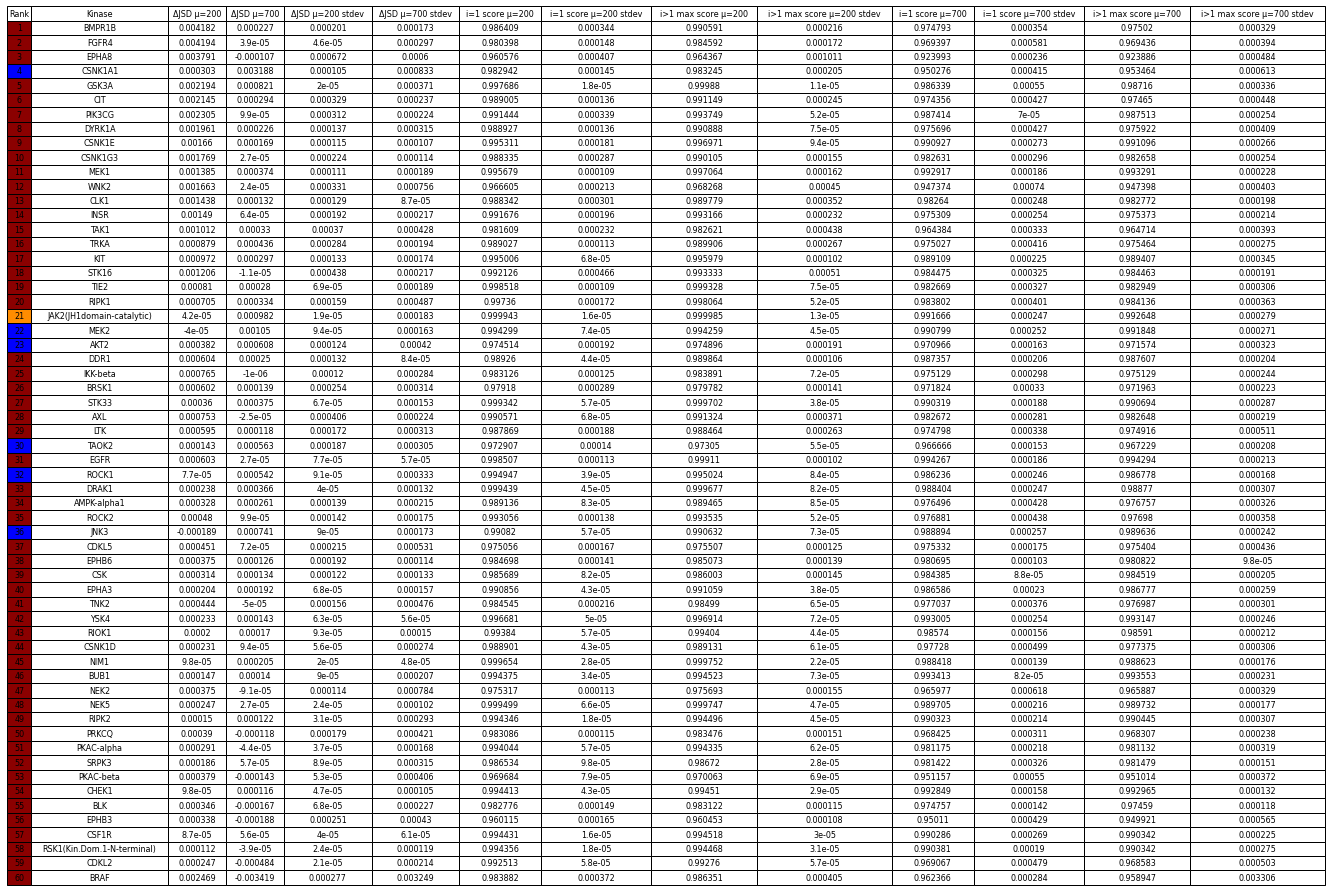

In [13]:
#Who are the kinases that showed statistically significant improvement?

n700 = 0
n200 = 0
both = 0

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    std200 = final_std_200[i]
    std700 = final_std_700[i]
    #original scores
    i1_200_score = final_JSD_200_i1[i]
    max_200_score = final_JSD_200_max[i]
    i1_200_score_stdev = final_JSD_200_i1_stdev[i]
    max_200_score_stdev = final_JSD_200_max_stdev[i]
    i1_700_score = final_JSD_700_i1[i]
    max_700_score = final_JSD_700_max[i]
    i1_700_score_stdev = final_JSD_700_i1_stdev[i]
    max_700_score_stdev = final_JSD_700_max_stdev[i]
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=1:
        scolor = 'w'
        if sig == 1:
            n200 += 1
            scolor = 'darkred'
        if sig == 2:
            n700 += 1
            scolor = 'b'
        if sig == 3:
            both += 1
            scolor = 'darkorange'
        res.append((tscore,k,mu200,mu700,std200,std700,
                    i1_200_score,i1_200_score_stdev,max_200_score,max_200_score_stdev,
                    i1_700_score,i1_700_score_stdev,max_700_score,max_700_score_stdev,scolor))
            
tabled = []
cell_color = []
tabled.append(['Rank','Kinase','ΔJSD μ=200','ΔJSD μ=700','ΔJSD μ=200 stdev', 'ΔJSD μ=700 stdev',
               'i=1 score μ=200','i=1 score μ=200 stdev','i>1 max score μ=200','i>1 max score μ=200 stdev',
               'i=1 score μ=700','i=1 score μ=700 stdev','i>1 max score μ=700','i>1 max score μ=700 stdev'])
cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])


            
print('average 200 i=1 score:' + str(np.mean(mu200)))
print('average 700 i=1 score:' + str(np.mean(mu700)))
print(n700,n200,both)
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=700')
counter = 1
for k in res:
    tabled.append([counter,k[1],round(k[2], 6),round(k[3],6),round(k[4],6),round(k[5],6),
                  round(k[6],6), round(k[7],6), round(k[8],6), round(k[9],6),
                  round(k[10],6), round(k[11],6), round(k[12],6), round(k[13],6)])
    color_val = k[14]
    cell_color.append([color_val,'w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #if k[2] > 0.001 or k[3]>0.001:
    #    cell_color.append(['w','#56b5fd','w','w','w','w','w','w','w','w','w','w','w','w'])
    #else:
    #    cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #print(counter,k[1],k[2],k[3])
    counter+=1
    
fig, ax = plt.subplots()
table = ax.table(cellText=tabled, loc='center',cellLoc='center',cellColours=cell_color)
table.auto_set_font_size(False)
table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
table.set_fontsize(8)
table.scale(1,1.2)
ax.axis('off')
plt.show()
#fig.savefig("120821_PKIS2_JSD_700v200_45k_improvement_table.pdf", bbox_inches='tight',dpi=500)

In [ ]:
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################
##################################################

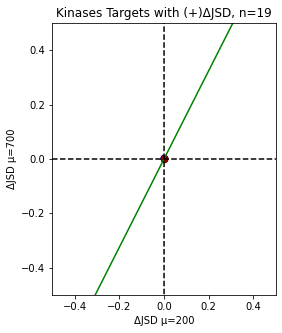

In [14]:
##################################################

# Same as above but set a threshold for changes that are more relevant versus less relevant
# Count the number of kinases that fall over this threshold

#check to see what the maximum inhibitor concentration # is that we should use
max_inhib_num = len(test_results_200[0])

#for each kinase, get the set of scores at i=1, i=2, i=3 etc

organized_results_200 = {}
organized_results_700 = {}

off_target_values_200 = {}
off_target_values_700 = {}

for replicate_200 in test_results_200:    #in each of the 5 test replicates
    for individual_result in replicate_200:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        off_target_values = individual_result[1][3]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_200:
                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                off_target_values_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            off_target_values_200[k_names[i]][inhibitor_combination_number-1].append(off_target_values[i])
            
for replicate_700 in test_results_700:    #in each of the 5 test replicates
    for individual_result in replicate_700:    #for each combination
        inhibitor_combination_number = individual_result[0]     
        k_names = individual_result[1][1]
        JS_scores = individual_result[1][2]
        off_target_values = individual_result[1][3]
        for i in range(0, len(k_names)):
            if k_names[i] not in organized_results_700:
                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                off_target_values_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])
            off_target_values_700[k_names[i]][inhibitor_combination_number-1].append(off_target_values[i])

#determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
#and if that difference is significant or not

x_200_scored_kinase_names = []
x_200_values = []
x_sig = []
max_200_vals = []
stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_200_i1_scores = [] #the raw scores
JSD_200_max_scores = [] #the raw scores
off_target_values_u200 = []
off_target_values_i1_u200 = []

y_700_scored_kinase_names = []
y_700_values = []
y_sig = []
max_700_vals = []
stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
JSD_700_i1_scores = [] #the raw scores
JSD_700_max_scores = [] #the raw scores
off_target_values_u700 = []
off_target_values_i1_u700 = []

for kinase in organized_results_200:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_200[kinase][0])
    i1_values = organized_results_200[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    best_combination_number = None
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_200[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_200[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_200[kinase][j]
                best_combination_number = j+1
    if max_other_combination_values != []:
        max_200_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_200.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
            significant = 1
        JS_score_difference = max_other_combination - i1_mean
        x_200_scored_kinase_names.append(kinase)
        x_200_values.append(JS_score_difference)
        x_sig.append(significant)
        JSD_200_i1_scores.append(i1_values)
        JSD_200_max_scores.append(max_other_combination_values)
        off_target_values_u200.append(off_target_values_200[kinase][best_combination_number-1]) #due to 0 indexing
        off_target_values_i1_u200.append(off_target_values_200[kinase][0])
    
for kinase in organized_results_700:
    #get the i=1 conition
    i1_mean = np.mean(organized_results_700[kinase][0])
    i1_values = organized_results_700[kinase][0]
    max_other_combination = 0
    max_other_combination_values = []
    significant = 0
    best_combination_number = None
    #compare to higher combination #s
    for j in range(1, max_inhib_num):
        if organized_results_700[kinase][j] != []:
            i_combo_mean = np.mean(organized_results_700[kinase][j])
            if i_combo_mean > max_other_combination:
                max_other_combination = i_combo_mean
                max_other_combination_values = organized_results_700[kinase][j]
                best_combination_number = j+1
    if max_other_combination_values != []:
        max_700_vals.append(max_other_combination)
        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
        stdev = np.std(differences)
        stdevs_700.append(stdev)
        #is the difference significant?
        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
            significant = 2
        JS_score_difference = max_other_combination - i1_mean
        y_700_scored_kinase_names.append(kinase)
        y_700_values.append(JS_score_difference)
        y_sig.append(significant)
        JSD_700_i1_scores.append(i1_values)
        JSD_700_max_scores.append(max_other_combination_values)
        off_target_values_u700.append(off_target_values_700[kinase][best_combination_number-1]) #due to 0 indexing
        off_target_values_i1_u700.append(off_target_values_700[kinase][0])
        
#for each kinase in PKIS2, get the x_val, the y_val, the total significance

final_kinases = []
final_x = []
final_y = []
sum_sig = []

final_std_200 = []
final_std_700 = []

final_JSD_200_i1 = []
final_JSD_700_i1 = []
final_JSD_200_max = []
final_JSD_700_max = []

final_JSD_200_i1_stdev = []
final_JSD_700_i1_stdev = []
final_JSD_200_max_stdev = []
final_JSD_700_max_stdev = []

final_200_off_target_values = []
final_700_off_target_values = []

final_i1_200_off_target_values = []
final_i1_700_off_target_values = []

for kinase_target in all_kinase_names:
    #final_kinases.append(kinase_target)
    
    add = False
    x_index = None
    y_index = None
    
    if kinase_target in x_200_scored_kinase_names:
        x_index = x_200_scored_kinase_names.index(kinase_target)
        #final_x.append(x_200_values[x_index])
        if x_sig[x_index] > 0:
            add=True
        #sum_sig.append(x_sig[index])
    #else:
        #final_x.append(0)
        #sum_sig.append(0)
    if kinase_target in y_700_scored_kinase_names:
        y_index = y_700_scored_kinase_names.index(kinase_target)
        if y_sig[y_index] > 0:
            add = True
        #final_y.append(y_700_values[index])
        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
    #else:
        #final_y.append(0)
    if add:
        final_x.append(x_200_values[x_index])
        final_y.append(y_700_values[y_index])
        sum_sig.append(x_sig[x_index]+y_sig[y_index])
        final_kinases.append(kinase_target)
        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score
        
        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))
        
        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
        
        final_200_off_target_values.append(off_target_values_u200[x_index])
        final_700_off_target_values.append(off_target_values_u700[y_index])
        
        final_i1_200_off_target_values.append(off_target_values_i1_u200[x_index])
        final_i1_700_off_target_values.append(off_target_values_i1_u700[y_index])
        
#convert significane to a different color for the points
#black = not significant
#yellow = significant for 200 (1)
#blue = significant for 700 (2)
#cyan = significant for both (3)
point_color = []
total = 0
for value in sum_sig:
    if value == 1:
        point_color.append('darkred')
        total+=1
    elif value == 2:
        point_color.append('b')
        total+=1
    elif value == 3:
        point_color.append('darkorange')
        total+=1
    else:
        point_color.append('k')
       
fig = plt.figure(figsize=(4, 5))
plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
        #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k--')
plt.plot(zeros,yv,'k--')

plt.show()

#fig.savefig("120121_PKIS2_JSD_700v200_scatterplot.pdf", bbox_inches='tight',dpi=500)

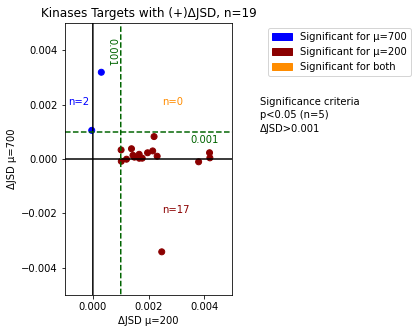

In [17]:
#replot with tighter axis
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(3, 5))

mu700 = [] #the i=1 scores
mu200 = [] #the i=1 scores
for kinase in organized_results_700:
    mu700.append(np.mean(organized_results_700[kinase][0]))
for kinase in organized_results_200:
    mu200.append(np.mean(organized_results_200[kinase][0]))
slope = (1 - np.mean(mu700)) / (1 - np.mean(mu200))
xv = np.arange(-1,1,0.001)
yv = xv*slope

zeros = xv*0

#plt.plot(xv,yv,color='g')

plt.plot(xv,zeros,'k-')
plt.plot(zeros,yv,'k-')

threshlimit = np.arange(-1,1,0.0001)
tlim = [0.001]*len(threshlimit)

plt.plot(threshlimit,tlim,'--',color='darkgreen')
plt.plot(tlim,threshlimit,'--',color='darkgreen')

plt.scatter(final_x, final_y, c=point_color)
#total = 0
#for i, label in enumerate(final_kinases):
    #if final_x[i] > 0.025 or final_y[i] > (0.025*1.8): 
    #plt.annotate(label, (final_x[i], final_y[i]))
#    if final_x[i] > 0 or final_y[i] >0:
#        total += 1
plt.xlim((-0.001,0.005))
plt.ylim((-0.005,0.005))
plt.xlabel('ΔJSD μ=200')
plt.ylabel('ΔJSD μ=700')
title = 'Kinases Targets with (+)ΔJSD, n=' + str(total)
plt.title(title)

#finally, add a line that represents an equal improvement to the maximum of 1 in both scales
#the 1 - average max(JSD at i=1) at mu=700 / 1 - average max(JSD at i=1) at mu=200, gives the slope
#essentially, its a scaled measure of how much improvement in the score is possible relative to a maximum of 1.
#note - since it represents the average change, it is possible for some points to represent statistically significant change on one axis but NOT the other
u700ldg = mpatches.Patch(color='b', label='Significant for μ=700')
u200ldg = mpatches.Patch(color='darkred', label='Significant for μ=200')
bothldg = mpatches.Patch(color='darkorange', label='Significant for both')

fig.legend(handles=[u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.75, 0.88))

plt.text(0.0035,0.0006,'0.001', color='darkgreen')
plt.text(0.0005,0.0035,'0.001', color='darkgreen',rotation=-90)

plt.text(-0.0009,0.002,'n=2', color='b')
plt.text(0.0025,-0.002,'n=17', color='darkred')
plt.text(0.0025,0.002,'n=0', color='darkorange')

plt.text(0.006,0.002,'Significance criteria')
plt.text(0.006,0.0015,'p<0.05 (n=5)')
plt.text(0.006,0.001,'ΔJSD>0.001')

plt.show()

fig.savefig("120921_PKIS2_JSD_700v200_scatterplot_19sig_zoomin.pdf", bbox_inches='tight',dpi=500)

average 200 i=1 score:0.0016627075138977432
average 700 i=1 score:2.4034620114354865e-05
2 17 0
kinase ΔJSD_μ=200 ΔJSD_μ=700


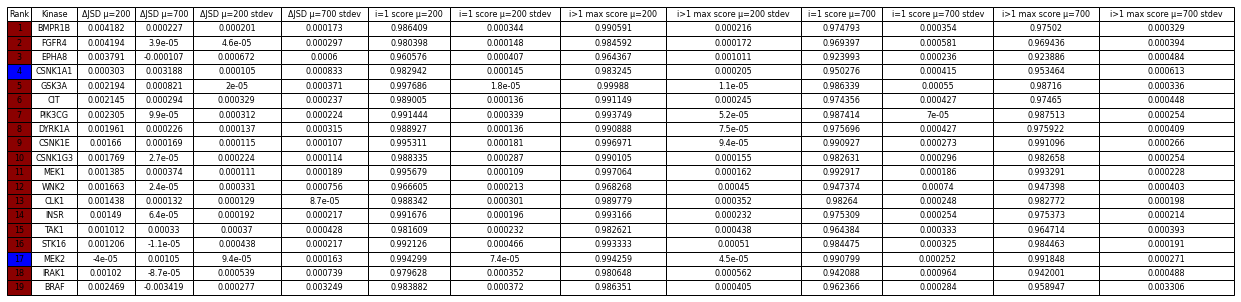

In [15]:
#Who are the kinases that showed statistically significant improvement?

n700 = 0
n200 = 0
both = 0

res = []
for i in range(0, len(final_kinases)):
    k = final_kinases[i]
    mu200 = final_x[i]
    mu700 = final_y[i]
    tscore = mu200+mu700
    std200 = final_std_200[i]
    std700 = final_std_700[i]
    #original scores
    i1_200_score = final_JSD_200_i1[i]
    max_200_score = final_JSD_200_max[i]
    i1_200_score_stdev = final_JSD_200_i1_stdev[i]
    max_200_score_stdev = final_JSD_200_max_stdev[i]
    i1_700_score = final_JSD_700_i1[i]
    max_700_score = final_JSD_700_max[i]
    i1_700_score_stdev = final_JSD_700_i1_stdev[i]
    max_700_score_stdev = final_JSD_700_max_stdev[i]
    if mu200 == 0:
        mu200 = 'N/A'
    if mu700 == 0:
        mu700 = 'N/A'
    sig = sum_sig[i]
    if sig>=1:
        scolor = 'w'
        if sig == 1:
            n200 += 1
            scolor = 'darkred'
        if sig == 2:
            n700 += 1
            scolor = 'b'
        if sig == 3:
            both += 1
            scolor = 'darkorange'
        res.append((tscore,k,mu200,mu700,std200,std700,
                    i1_200_score,i1_200_score_stdev,max_200_score,max_200_score_stdev,
                    i1_700_score,i1_700_score_stdev,max_700_score,max_700_score_stdev,scolor))
            
tabled = []
cell_color = []
tabled.append(['Rank','Kinase','ΔJSD μ=200','ΔJSD μ=700','ΔJSD μ=200 stdev', 'ΔJSD μ=700 stdev',
               'i=1 score μ=200','i=1 score μ=200 stdev','i>1 max score μ=200','i>1 max score μ=200 stdev',
               'i=1 score μ=700','i=1 score μ=700 stdev','i>1 max score μ=700','i>1 max score μ=700 stdev'])
cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])


            
print('average 200 i=1 score:' + str(np.mean(mu200)))
print('average 700 i=1 score:' + str(np.mean(mu700)))
print(n700,n200,both)
res = sorted(res, key=lambda x: x[0], reverse=True)
print('kinase','ΔJSD_μ=200','ΔJSD_μ=700')
counter = 1
for k in res:
    tabled.append([counter,k[1],round(k[2], 6),round(k[3],6),round(k[4],6),round(k[5],6),
                  round(k[6],6), round(k[7],6), round(k[8],6), round(k[9],6),
                  round(k[10],6), round(k[11],6), round(k[12],6), round(k[13],6)])
    #if k[2] > 0.001 or k[3]>0.001:
    color_val = k[14]
    cell_color.append([color_val,'w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #else:
    #cell_color.append(['w','w','w','w','w','w','w','w','w','w','w','w','w','w'])
    #print(counter,k[1],k[2],k[3])
    counter+=1
    
fig, ax = plt.subplots()
table = ax.table(cellText=tabled, loc='center',cellLoc='center',cellColours=cell_color)
table.auto_set_font_size(False)
table.auto_set_column_width(col=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
table.set_fontsize(8)
table.scale(1,1.2)
ax.axis('off')
plt.show()
#fig.savefig("120821_PKIS2_JSD_700v200_19k_improvement_table.pdf", bbox_inches='tight',dpi=500)

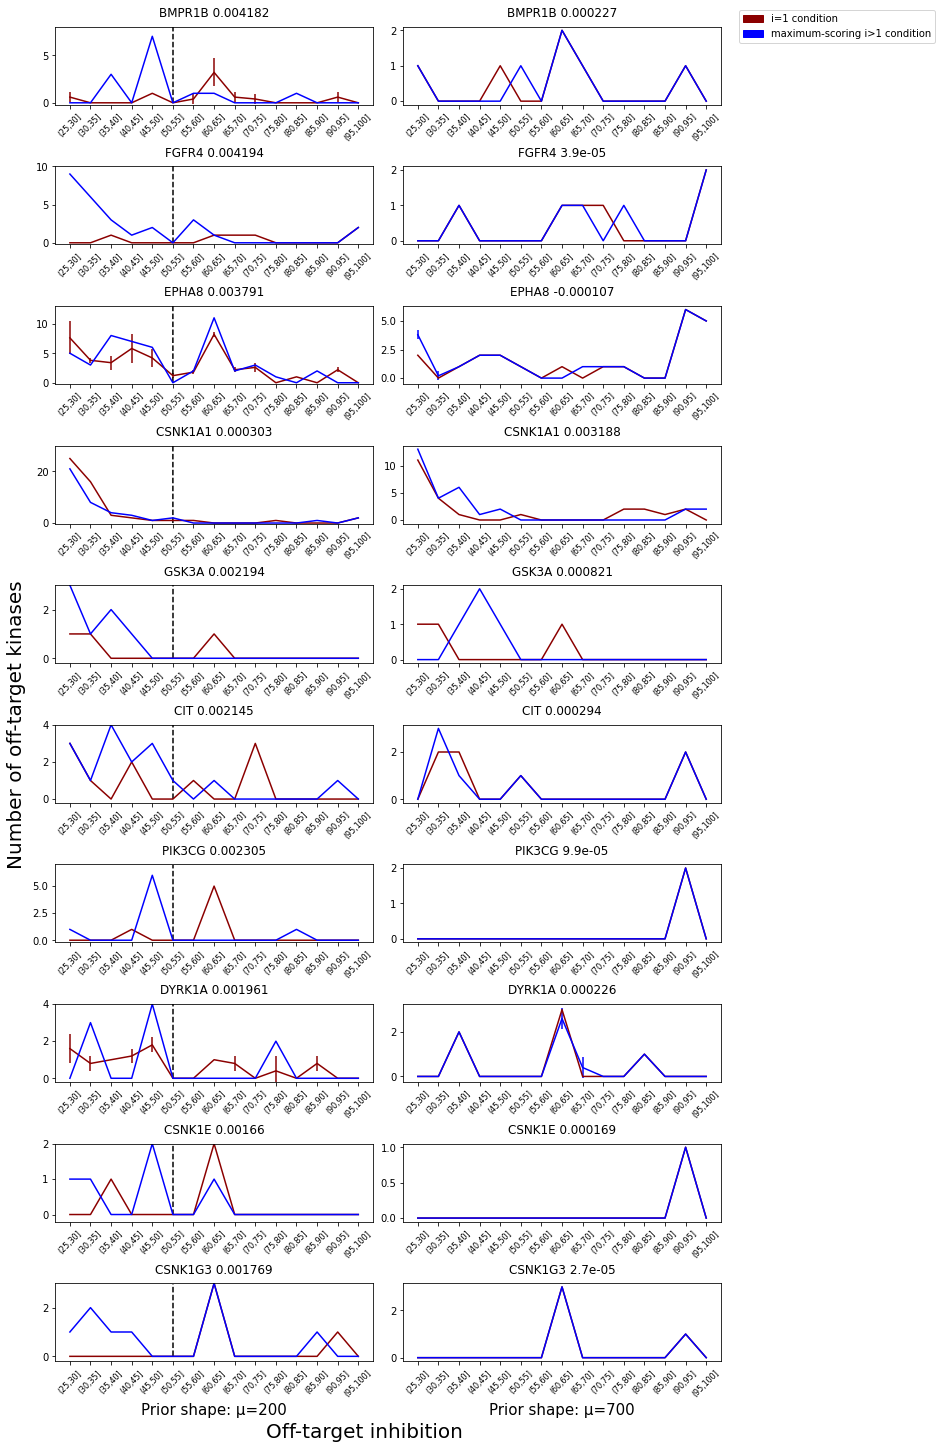

In [109]:
#Lets make a plot for each of these tracking the change in off-target activity and the number of off-target kinases
#We need to get all 5 groups of off-target values, and then average the 5 lists at each relative position
#Then we can plot the number of off-target kinases (+/- std for the 5 replicates) for the i=1 versus i>1 conditions

nrows = 10
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(10,20),constrained_layout=True)

fig.supxlabel('Off-target inhibition', fontsize=20)
fig.supylabel('Number of off-target kinases', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.3, 1))

axes[9][0].set_xlabel('Prior shape: μ=200',fontsize=15)
axes[9][1].set_xlabel('Prior shape: μ=700',fontsize=15)

for i in range(0, 10):
    k = res[i][1]
    score200 = res[i][2]
    score700 = res[i][3]
    
    index = final_kinases.index(k)
    
    off_target_200_i1_init = final_i1_200_off_target_values[index]
    off_target_700_i1_init = final_i1_700_off_target_values[index]
    
    off_target_200_max_init = final_200_off_target_values[index]
    off_target_700_max_init = final_700_off_target_values[index]
    
    ot_200_max = []
    ot_700_max = []
    i1_200 = []
    i1_700 = []
    
    for temp in off_target_200_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_200_max.append(vals)
        
    for temp in off_target_700_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_700_max.append(vals)
        
    for temp in off_target_200_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_200.append(vals)
        
    for temp in off_target_700_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_700.append(vals)
        
    #for each of the 5 technical replicates, construct bins for each
    #afterwards, we will average (an get the std) for each of the frequencies over the 5 technical replicates
    
    #print(i1_200)
    
    i1_200_binned = []
    
    for replicate in i1_200:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_200_binned.append(bins)
        
    i1_700_binned = []
    
    for replicate in i1_700:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_700_binned.append(bins)
        
        
    max_200_binned = []
    
    for replicate in ot_200_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_200_binned.append(bins)
        
    max_700_binned = []
    
    for replicate in ot_700_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_700_binned.append(bins)
        
    avg_i1_200=list(np.average(i1_200_binned, axis=0))
    std_i1_200=list(np.std(i1_200_binned, axis=0))
    
    avg_i1_700=list(np.average(i1_700_binned, axis=0))
    std_i1_700=list(np.std(i1_700_binned, axis=0))
    
    avg_max_200=list(np.average(max_200_binned, axis=0))
    std_max_200=list(np.std(max_200_binned, axis=0))
    
    avg_max_700=list(np.average(max_700_binned, axis=0))
    std_max_700=list(np.std(max_700_binned, axis=0))
    
    bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
    #only plot from 20 upwards
    bin_max_200 = bin_max[5:]
    avg_i1_200 = avg_i1_200[5:]
    std_i1_200 = std_i1_200[5:]
    avg_max_200 = avg_max_200[5:]
    std_max_200 = std_max_200[5:]
    
    bin_max_700 = bin_max[5:]
    avg_i1_700 = avg_i1_700[5:]
    std_i1_700 = std_i1_700[5:]
    avg_max_700 = avg_max_700[5:]
    std_max_700 = std_max_700[5:]
    
    ylim200_a = max(avg_i1_200)
    ylim200_b = max(avg_max_200)
    ylim_200 = max([ylim200_a,ylim200_b])
    
    axes[i][0].errorbar(bin_max_200, avg_i1_200, yerr=std_i1_200,xerr=None, color='darkred')
    axes[i][0].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
    axes[i][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
    axes[i][0].tick_params(axis='x', labelsize=8, rotation=45)
    
    axes[i][1].errorbar(bin_max_700, avg_i1_700, yerr=std_i1_700,xerr=None, color='darkred')
    axes[i][1].errorbar(bin_max_700, avg_max_700, yerr=std_max_700,xerr=None, color='blue')
    axes[i][1].set_title(k+' '+str(round(score700,6)), x=0.5, y=1.05)
    axes[i][1].tick_params(axis='x', labelsize=8, rotation=45)
    
    #add a vertical line to represent where the on-target prior becomes innefectual in either
    thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
    xlim = [5]*len(thresh1)
    axes[i][0].plot(xlim,thresh1,'k--')
    axes[i][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
fig.savefig("120821_PKIS2_JSD_700v200_19_kinase-specific-plots-1-2.pdf", bbox_inches='tight',dpi=500)

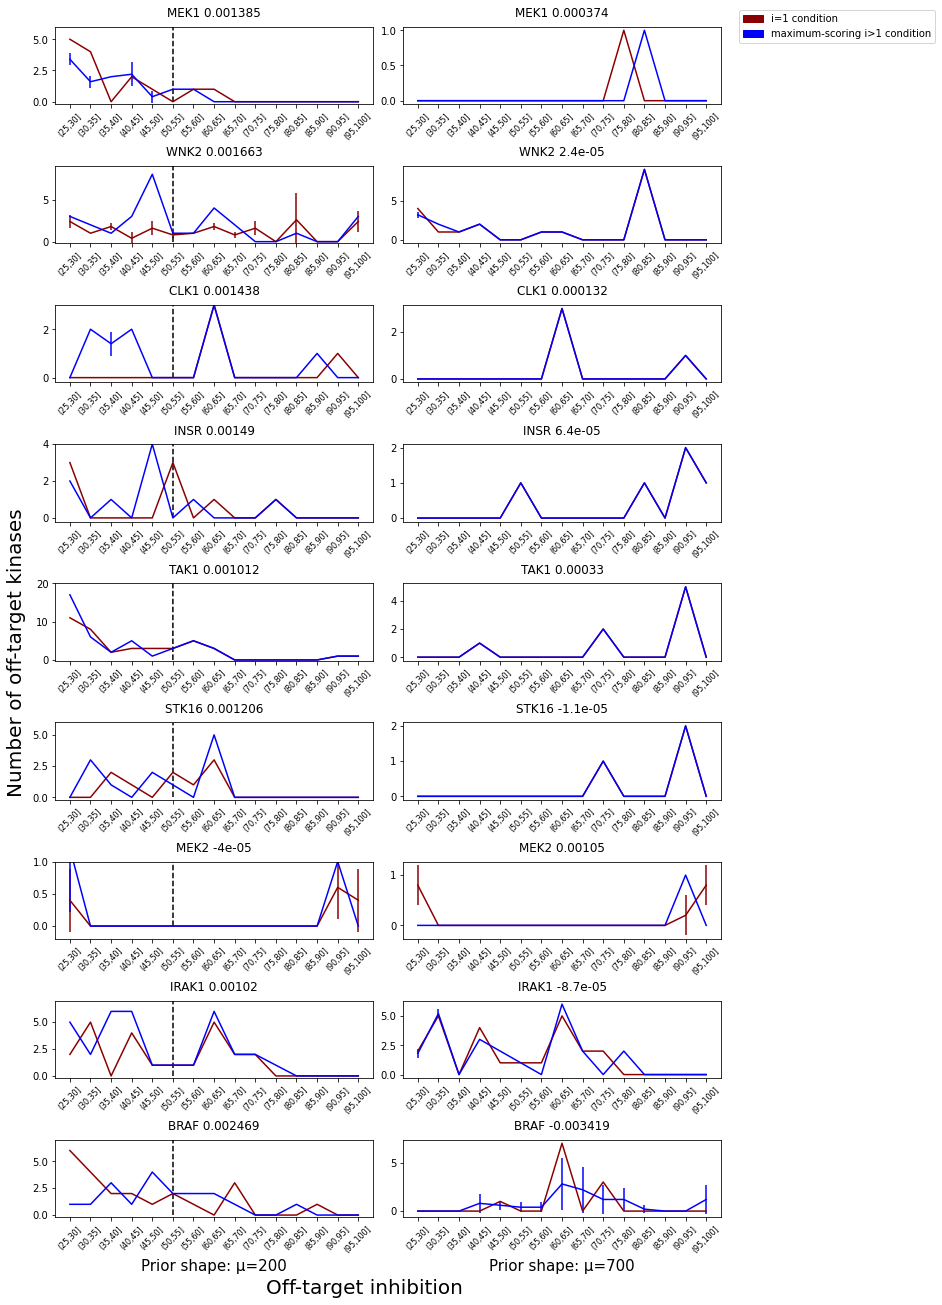

In [108]:
#Lets make a plot for each of these tracking the change in off-target activity and the number of off-target kinases
#We need to get all 5 groups of off-target values, and then average the 5 lists at each relative position
#Then we can plot the number of off-target kinases (+/- std for the 5 replicates) for the i=1 versus i>1 conditions

nrows = 9
ncols = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(10,18),constrained_layout=True)

fig.supxlabel('Off-target inhibition', fontsize=20)
fig.supylabel('Number of off-target kinases', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.3, 1))

axes[8][0].set_xlabel('Prior shape: μ=200',fontsize=15)
axes[8][1].set_xlabel('Prior shape: μ=700',fontsize=15)

for i in range(10, len(res)):
    k = res[i][1]
    score200 = res[i][2]
    score700 = res[i][3]
    
    index = final_kinases.index(k)
    
    off_target_200_i1_init = final_i1_200_off_target_values[index]
    off_target_700_i1_init = final_i1_700_off_target_values[index]
    
    off_target_200_max_init = final_200_off_target_values[index]
    off_target_700_max_init = final_700_off_target_values[index]
    
    ot_200_max = []
    ot_700_max = []
    i1_200 = []
    i1_700 = []
    
    for temp in off_target_200_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_200_max.append(vals)
        
    for temp in off_target_700_max_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        ot_700_max.append(vals)
        
    for temp in off_target_200_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_200.append(vals)
        
    for temp in off_target_700_i1_init:
        vals = (temp[1:-1]).split(', ')
        vals = [float(x) for x in vals]
        i1_700.append(vals)
        
    #for each of the 5 technical replicates, construct bins for each
    #afterwards, we will average (an get the std) for each of the frequencies over the 5 technical replicates
    
    #print(i1_200)
    
    i1_200_binned = []
    
    for replicate in i1_200:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_200_binned.append(bins)
        
    i1_700_binned = []
    
    for replicate in i1_700:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        i1_700_binned.append(bins)
        
        
    max_200_binned = []
    
    for replicate in ot_200_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_200_binned.append(bins)
        
    max_700_binned = []
    
    for replicate in ot_700_max:
        bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
        for x in range(0, len(replicate)): #for every point in the set of sample noise (100 per measrument), add it to the distribution
            temp = int(replicate[x]/5)
            if temp < 20 and temp >= 0:
                bins[temp] += 1.0
            elif temp >= 20:
                bins[len(bins)-1] += 1.0
            else:
                bins[0] += 1.0
        max_700_binned.append(bins)
        
    avg_i1_200=list(np.average(i1_200_binned, axis=0))
    std_i1_200=list(np.std(i1_200_binned, axis=0))
    
    avg_i1_700=list(np.average(i1_700_binned, axis=0))
    std_i1_700=list(np.std(i1_700_binned, axis=0))
    
    avg_max_200=list(np.average(max_200_binned, axis=0))
    std_max_200=list(np.std(max_200_binned, axis=0))
    
    avg_max_700=list(np.average(max_700_binned, axis=0))
    std_max_700=list(np.std(max_700_binned, axis=0))
    
    bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
    #only plot from 20 upwards
    bin_max_200 = bin_max[5:]
    avg_i1_200 = avg_i1_200[5:]
    std_i1_200 = std_i1_200[5:]
    avg_max_200 = avg_max_200[5:]
    std_max_200 = std_max_200[5:]
    
    bin_max_700 = bin_max[5:]
    avg_i1_700 = avg_i1_700[5:]
    std_i1_700 = std_i1_700[5:]
    avg_max_700 = avg_max_700[5:]
    std_max_700 = std_max_700[5:]
    
    ylim200_a = max(avg_i1_200)
    ylim200_b = max(avg_max_200)
    ylim_200 = max([ylim200_a,ylim200_b])
    
    
    
    axes[i-10][0].errorbar(bin_max_200, avg_i1_200, yerr=std_i1_200,xerr=None, color='darkred')
    axes[i-10][0].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
    axes[i-10][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
    axes[i-10][0].tick_params(axis='x', labelsize=8, rotation=45)
    
    axes[i-10][1].errorbar(bin_max_700, avg_i1_700, yerr=std_i1_700,xerr=None, color='darkred')
    axes[i-10][1].errorbar(bin_max_700, avg_max_700, yerr=std_max_700,xerr=None, color='blue')
    axes[i-10][1].set_title(k+' '+str(round(score700,6)), x=0.5, y=1.05)
    axes[i-10][1].tick_params(axis='x', labelsize=8, rotation=45)
    
    #add a vertical line to represent where the on-target prior becomes innefectual in either
    thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
    xlim = [5]*len(thresh1)
    axes[i-10][0].plot(xlim,thresh1,'k--')
    axes[i-10][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
fig.savefig("120821_PKIS2_JSD_700v200_19_kinase-specific-plots-2-2.pdf", bbox_inches='tight',dpi=500)